In [52]:
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math, json
import numpy as np

import gymnasium as gym
import matplotlib.pyplot as plt

In [53]:
NUM_RUNS = 1

A = 256      # dimension of each hidden layer
B = 2       # number of hidden layers
C = 5e-3    # stochastic gradient descent learning rate
D = 3600      # maximum numbers of transitions stored by replay buffer
E = 300     # number of episodes of learning running the task
F = 1     # epsilon probability of eps-greedy policy
G = 0.99    # reward discounting factor
H = 128     # replay buffer sample size
I = 50      # The interval between two consecutive target network update

In [ ]:
runs_results = []

env = gym.make('CartPole-v1')
for run in range(NUM_RUNS):
    print(f"Starting run {run+1} of {NUM_RUNS}")
    layers = [4] + [A]*B + [2]
    # layers = [4] + [8, 32, 8] + [2]
    policy_net = DQN(layers)
    target_net = DQN(layers)
    update_target(target_net, policy_net)
    target_net.eval()

    optimizer = optim.SGD(policy_net.parameters(), lr=C)
    memory = ReplayBuffer(D)

    steps_done = 0
    episode_durations = []
    eps_decay = 1
    for i_episode in range(1, E+1):            
        if i_episode % 20 == 0:
            print("episode ", i_episode, "/", eps_decay, "...", episode_durations[-20:])
            
        observation, info = env.reset()
        state = torch.tensor(observation).float()

        done = False
        terminated = False
        t = 0
        while not (done or terminated):

            # Select and perform an action
            action = epsilon_greedy(F*eps_decay, policy_net, state)

            observation, reward, done, terminated, info = env.step(action)
            reward = torch.tensor([reward])/G
            action = torch.tensor([action])
            next_state = torch.tensor(observation).reshape(-1).float()

            memory.push([state, action, next_state, reward, torch.tensor([done])])

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            if not len(memory.buffer) < H:
                transitions = memory.sample(H)
                state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                # Compute loss
                mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                # Optimize the model
                optimizer.zero_grad()
                mse_loss.backward()
                optimizer.step()
            
            if done or terminated:
                episode_durations.append(t + 1)
            t += 1
            steps_done += 1
            # Update the target network, copying all weights and biases in DQN
            if steps_done % I == 0: 
                update_target(target_net, policy_net)

        if i_episode > 5 and eps_decay > 10e-3:
            eps_decay *= 0.98
            optimizer.param_groups[0]["lr"] *= 0.98
    runs_results.append(episode_durations)
    
with open("reward.json", "w") as f:
    json.dump(runs_results, f)
torch.save(policy_net.state_dict(), "policy.json")
print('Complete', steps_done)

Starting run 1 of 1
episode  20 / 0.7536419414749017 ... [16, 56, 21, 16, 11, 18, 20, 19, 31, 17, 16, 15, 12, 28, 14, 19, 10, 13, 10]
episode  40 / 0.5031373679776306 ... [15, 12, 14, 17, 18, 15, 14, 16, 23, 12, 14, 15, 13, 9, 23, 21, 10, 12, 56, 21]
episode  60 / 0.33589851774974244 ... [21, 23, 66, 32, 56, 108, 46, 89, 61, 60, 70, 40, 47, 80, 81, 50, 81, 46, 117, 38]
episode  80 / 0.22424852815044813 ... [68, 79, 142, 157, 116, 115, 178, 500, 60, 281, 165, 328, 134, 41, 229, 256, 263, 235, 364, 392]
episode  100 / 0.14971010504758586 ... [260, 303, 291, 219, 226, 216, 200, 223, 209, 209, 201, 178, 191, 179, 194, 176, 197, 207, 186, 205]
episode  120 / 0.09994765958206091 ... [182, 209, 264, 228, 245, 350, 343, 309, 197, 315, 296, 162, 279, 245, 334, 257, 345, 233, 327, 296]
episode  140 / 0.06672585429524831 ... [350, 249, 298, 262, 327, 337, 396, 268, 290, 416, 493, 325, 336, 352, 385, 359, 500, 477, 500, 500]
episode  160 / 0.04454671224967667 ... [500, 500, 500, 500, 500, 500, 499

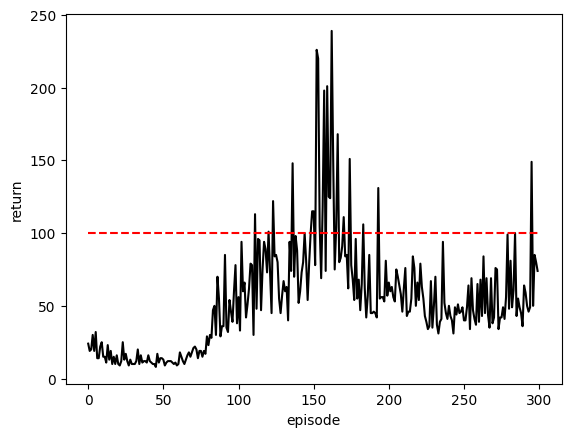

In [ ]:
# Plotting the learning curve
# Placeholder plot, you are free to modify it

# with open("reward.json", "r") as f:
#     runs_results = json.load(f)
num_episodes = len(runs_results[0])
 
results = torch.tensor(runs_results)
means = results.float().mean(0)
stds = results.float().std(0)

plt.plot(torch.arange(num_episodes), means, color='k')
plt.hlines(100, 0, num_episodes,"r", "dashed")
plt.ylabel("return")
plt.xlabel("episode")
plt.fill_between(np.arange(num_episodes), means, means+stds, alpha=0.3, color='b')
plt.fill_between(np.arange(num_episodes), means, means-stds, alpha=0.3, color='b')
plt.show()

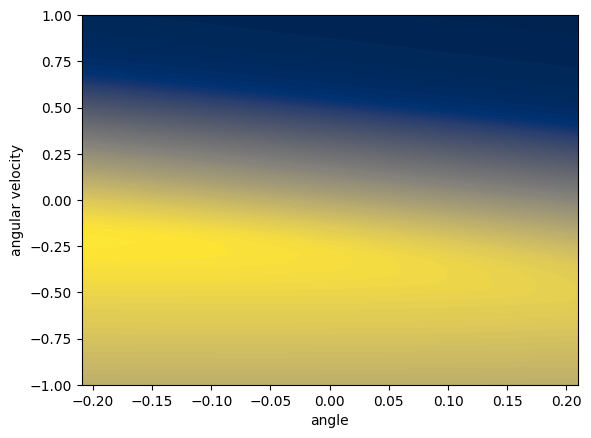

In [ ]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders and you can freely modify these plots and code

# Make sure to include appropriate labels and/or legends when presenting your plot

# policy_net = policy_net   # randomly initialised, replace with your trained DQN
q = True    # whether q values or greedy policy is visualised

angle_range = .2095 # you may modify this range
omega_range = 1     # you may modify this range

angle_samples = 100
omega_samples = 100
angles = torch.linspace(angle_range, -angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)

greedy_q_array = torch.zeros((angle_samples, omega_samples))
policy_array = torch.zeros((angle_samples, omega_samples))
for i, angle in enumerate(angles):
    for j, omega in enumerate(omegas):
        state = torch.tensor([0., 0., angle, omega])
        with torch.no_grad():
            q_vals = policy_net(state)
            greedy_action = q_vals.argmax()
            greedy_q_array[i, j] = q_vals[greedy_action]
            policy_array[i, j] = greedy_action
if q:
    plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
else:
    plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
plt.xlabel("angle")
plt.ylabel("angular velocity")
plt.show()